<a href="https://colab.research.google.com/github/KimGriezmann/Bigcontest_2021/blob/master/working_space_SeongGwan/Bigcontest_Barrel_def.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

plt.rc('font', family='NanumBarunGothic') 

In [3]:
df = pd.read_csv('/content/drive/MyDrive/빅콘테스트/Bigcontest_df.csv', index_col=0)
df.head()

,DATE,PCODE,INN,HIT_VEL,HIT_ANG_VER,HIT_RESULT,PIT_VEL,PIT_ID,G_ID,RESULT_MG,order,NAME,POSITION,result,before,after,LEV,REa,WPs,WPe,WPa,P,pitcher,batter,vs
0,20180324,62797,1,131.50,42.7,플라이,149.59,180324_140436,20180324HHWO0,플라이,0.0,양성우,외,뜬공,1사 0:0,2사 0:0,0.62,-0.180,52.2,53.8,-0.016,1-2,로저스,양성우,넥센
1,20180324,76753,1,135.18,9.9,1루타,148.78,180324_140514,20180324HHWO0,1루타,0.0,송광민,내,안타,2사 0:0,2사 1루 0:0,0.40,0.134,53.8,52.6,0.012,0-0,로저스,송광민,넥센
2,20180324,71752,1,152.41,2.1,1루타,148.59,180324_140647,20180324HHWO0,1루타,0.0,김태균,내,안타,2사 1루 0:0,"2사 1,2루 0:0",0.79,0.215,52.6,50.6,0.020,0-2,로저스,김태균,넥센
3,20180324,62700,1,113.72,13.5,1루타,139.13,180324_140911,20180324HHWO0,1루타,0.0,하주석,내,안타,"2사 1,2루 0:0","2사 1,2루 1:0",1.62,1.000,50.6,40.7,0.099,2-1,로저스,하주석,넥센
4,20180324,78288,2,161.90,3.5,1루타,145.75,180324_142310,20180324HHWO0,1루타,0.0,최재훈,포,안타,무사 2루 1:0,"무사 1,3루 1:0",1.13,0.715,33.8,27.9,0.059,0-2,로저스,최재훈,넥센


# 범위 나눠서 배럴 찾아보기

In [4]:
df['RESULT_MG'].value_counts()

플라이     42196
땅볼      29347
1루타     29093
2루타      8116
홈런       4718
직선타      3576
내야안타     1788
3루타       670
Name: RESULT_MG, dtype: int64

In [5]:
print( '타구속도 범위 : {} km/h ~ {} km/h\n발사각도 범위 : {}º ~ {}º'.format(df['HIT_VEL'].min(), df['HIT_VEL'].max(), df['HIT_ANG_VER'].min(), df['HIT_ANG_VER'].max()) )

타구속도 범위 : 26.29 km/h ~ 210.13 km/h
발사각도 범위 : -68.1º ~ 89.8º


In [6]:
HA = {'1루타':'hit', '2루타':'hit', '홈런':'hit', '3루타':'hit', '플라이':'out', '땅볼':'out', '직선타':'out', '내야안타':'hit'}
HA2 = {'1루타':'hit', '2루타':'hit', '홈런':'hit', '3루타':'hit', '플라이':'out', '땅볼':'out', '직선타':'hit', '내야안타':'hit'}
SLG = {'1루타':'1루타', '2루타':'2루타', '홈런':'홈런', '3루타':'3루타', '플라이':'out', '땅볼':'out', '직선타':'out', '내야안타':'1루타'}
SLG2 = {'1루타':'1루타', '2루타':'2루타', '홈런':'홈런', '3루타':'3루타', '플라이':'out', '땅볼':'out', '직선타':'1루타', '내야안타':'1루타'}

df['HA_result'] = df['RESULT_MG'].map(HA)
df['HA2_result'] = df['RESULT_MG'].map(HA2)
df['SLG_result'] = df['RESULT_MG'].map(SLG)
df['SLG2_result'] = df['RESULT_MG'].map(SLG2)

In [ ]:
# for vel in tqdm_notebook(range(25, 215, 5)) :
#     for ang in range(-70, 90, 2) :
#         tmp = df[(df['HIT_VEL'] >= vel) & (df['HIT_ANG_VER'] >= ang)]
#         total_num = len(tmp)
#         hit_num = list(tmp['HA_result']).count('hit')

#         result_HA = hit_num / total_num if total_num != 0  else 0

#         b1_num = list(tmp['SLG_result']).count('1루타')
#         b2_num = list(tmp['SLG_result']).count('2루타')
#         b3_num = list(tmp['SLG_result']).count('3루타')
#         hr_num = list(tmp['SLG_result']).count('홈런')

#         result_SLG = ((1*b1_num) + (2*b2_num) + (3*b3_num) + (4*hr_num)) / total_num if total_num != 0  else 0

#         if (result_HA >= 0.5) & (result_SLG >= 1.5):
#             print('타구속도 {} km/h 이상, 발사각도 {}º 이상인 타구'.format(vel, ang))

In [8]:
barrel_vel=[]
barrel_ang=[]
barrel_df = pd.DataFrame()

for vel in tqdm_notebook(range(25, 215, 5)) :
    for ang in range(-70, 90, 2) :
        tmp = df[(df['HIT_VEL'] >= vel) & (df['HIT_VEL'] < vel+5) & (df['HIT_ANG_VER'] >= ang) & (df['HIT_ANG_VER'] < ang+2)]
        total_num = len(tmp)
        hit_num = list(tmp['HA_result']).count('hit')

        result_HA = hit_num / total_num if total_num != 0  else 0

        b1_num = list(tmp['SLG_result']).count('1루타')
        b2_num = list(tmp['SLG_result']).count('2루타')
        b3_num = list(tmp['SLG_result']).count('3루타')
        hr_num = list(tmp['SLG_result']).count('홈런')

        result_SLG = ((1*b1_num) + (2*b2_num) + (3*b3_num) + (4*hr_num)) / total_num if total_num != 0  else 0

        if (result_HA >= 0.5) & (result_SLG >= 1.5) & (total_num >= 10):
            barrel_vel.append(vel)
            barrel_ang.append(ang)

barrel_df['VEL'] = barrel_vel
barrel_df['ANG'] = barrel_ang

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/38 [00:00<?, ?it/s]

In [9]:
barrel2_vel=[]
barrel2_ang=[]
barrel2_df = pd.DataFrame()

for vel in tqdm_notebook(range(25, 215, 5)) :
    for ang in range(-70, 90, 2) :
        tmp = df[(df['HIT_VEL'] >= vel) & (df['HIT_VEL'] < vel+5) & (df['HIT_ANG_VER'] >= ang) & (df['HIT_ANG_VER'] < ang+2)]
        total_num = len(tmp)
        hit_num = list(tmp['HA2_result']).count('hit')

        result_HA2 = hit_num / total_num if total_num != 0  else 0

        if (result_HA2 >= 0.7) & (total_num >= 10):
            barrel2_vel.append(vel)
            barrel2_ang.append(ang)

barrel2_df['VEL'] = barrel2_vel
barrel2_df['ANG'] = barrel2_ang

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/38 [00:00<?, ?it/s]

In [10]:
def group_fuc(x):
    d={}
    d['min'] = x['ANG'].min()
    d['max'] = x['ANG'].max()
    return pd.Series(d)

barrel_group = barrel_df.groupby(barrel_df['VEL']).apply(group_fuc)
barrel2_group = barrel2_df.groupby(barrel2_df['VEL']).apply(group_fuc)

In [11]:
barrel_group

,min,max
VEL,,
150,22,34
155,20,36
160,18,40
165,16,38
170,16,28


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


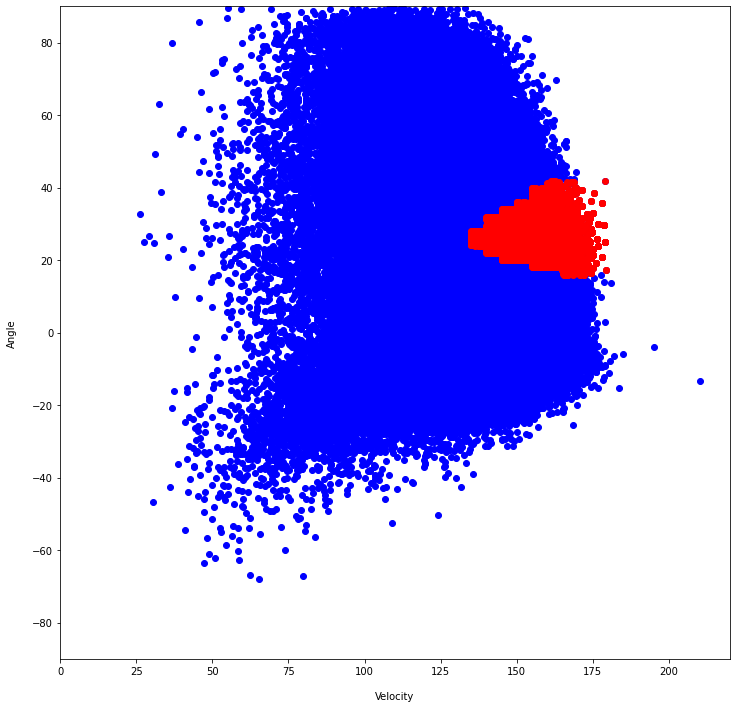

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
ax.set_xlabel('Velocity', labelpad=15)
ax.set_ylabel('Angle', labelpad=15)
ax.set_xlim([0, 220])
ax.set_ylim([-90, 90])
ax.scatter(df['HIT_VEL'], df['HIT_ANG_VER'], c='b')

tmp = df[(df['HIT_VEL'] >= 135) & (df['HIT_ANG_VER'] >= 24) & (df['HIT_ANG_VER'] <= 28)]
ax.scatter(tmp['HIT_VEL'], tmp['HIT_ANG_VER'], c='r')

tmp = df[(df['HIT_VEL'] >= 140) & (df['HIT_ANG_VER'] >= 22) & (df['HIT_ANG_VER'] <= 32)]
ax.scatter(tmp['HIT_VEL'], tmp['HIT_ANG_VER'], c='r')

tmp = df[(df['HIT_VEL'] >= 145) & (df['HIT_ANG_VER'] >= 20) & (df['HIT_ANG_VER'] <= 34)]
ax.scatter(tmp['HIT_VEL'], tmp['HIT_ANG_VER'], c='r')

tmp = df[(df['HIT_VEL'] >= 150) & (df['HIT_ANG_VER'] >= 20) & (df['HIT_ANG_VER'] <= 36)]
ax.scatter(tmp['HIT_VEL'], tmp['HIT_ANG_VER'], c='r')

tmp = df[(df['HIT_VEL'] >= 155) & (df['HIT_ANG_VER'] >= 18) & (df['HIT_ANG_VER'] <= 40)]
ax.scatter(tmp['HIT_VEL'], tmp['HIT_ANG_VER'], c='r')

tmp = df[(df['HIT_VEL'] >= 160) & (df['HIT_ANG_VER'] >= 18) & (df['HIT_ANG_VER'] <= 42)]
ax.scatter(tmp['HIT_VEL'], tmp['HIT_ANG_VER'], c='r')

tmp = df[(df['HIT_VEL'] >= 165) & (df['HIT_ANG_VER'] >= 16) & (df['HIT_ANG_VER'] <= 40)]
ax.scatter(tmp['HIT_VEL'], tmp['HIT_ANG_VER'], c='r')

tmp = df[(df['HIT_VEL'] >= 170) & (df['HIT_ANG_VER'] >= 16) & (df['HIT_ANG_VER'] <= 30)]
ax.scatter(tmp['HIT_VEL'], tmp['HIT_ANG_VER'], c='r')

plt.show()

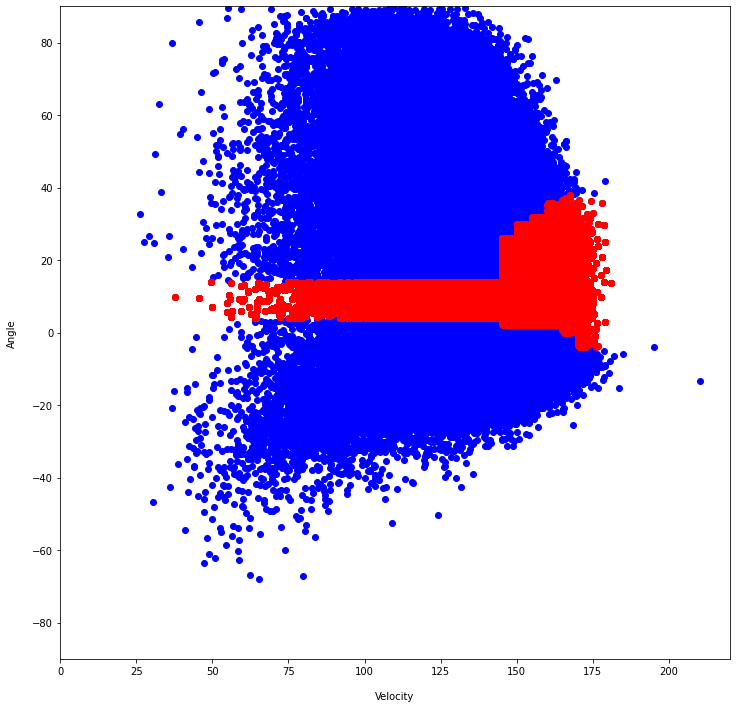

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
ax.set_xlabel('Velocity', labelpad=15)
ax.set_ylabel('Angle', labelpad=15)
ax.set_xlim([0, 220])
ax.set_ylim([-90, 90])
ax.scatter(df['HIT_VEL'], df['HIT_ANG_VER'], c='b')

for i in range(barrel2_group.shape[0]):
    vel = barrel2_group.index[i]
    min_ang = barrel2_group.iloc[i][0]
    max_ang = barrel2_group.iloc[i][1]
    tmp = df[(df['HIT_VEL'] >= vel) & (df['HIT_ANG_VER'] >= min_ang) & (df['HIT_ANG_VER'] <= max_ang)]
    ax.scatter(tmp['HIT_VEL'], tmp['HIT_ANG_VER'], c='r')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


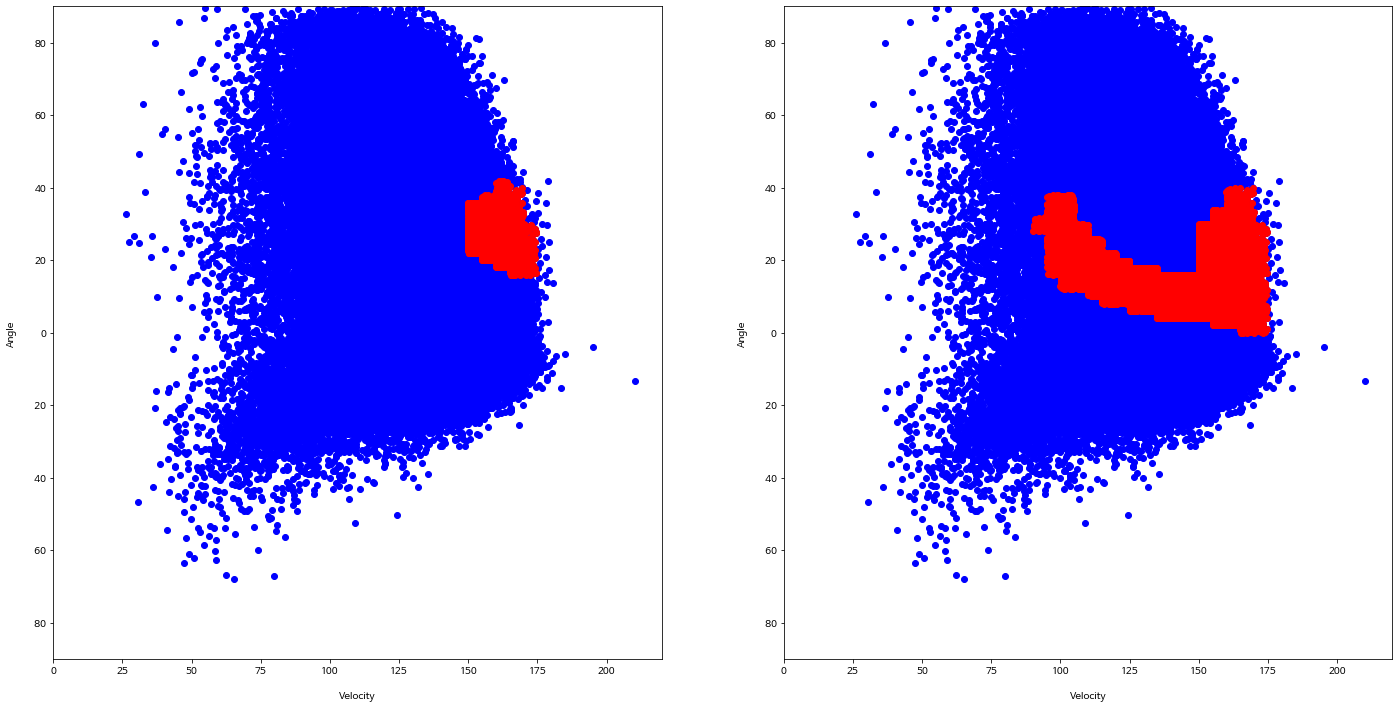

In [14]:
fig = plt.figure(figsize=(24,12))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.set_xlabel('Velocity', labelpad=15)
ax1.set_ylabel('Angle', labelpad=15)
ax1.set_xlim([0, 220])
ax1.set_ylim([-90, 90])
ax1.scatter(df['HIT_VEL'], df['HIT_ANG_VER'], c='b')
ax2.set_xlabel('Velocity', labelpad=15)
ax2.set_ylabel('Angle', labelpad=15)
ax2.set_xlim([0, 220])
ax2.set_ylim([-90, 90])
ax2.scatter(df['HIT_VEL'], df['HIT_ANG_VER'], c='b')

for i in range(barrel_group.shape[0]):
    vel = barrel_group.index[i]
    min_ang = barrel_group.iloc[i][0]
    max_ang = barrel_group.iloc[i][1]
    tmp = df[(df['HIT_VEL'] >= vel) & (df['HIT_VEL'] < vel+5) & (df['HIT_ANG_VER'] >= min_ang) & (df['HIT_ANG_VER'] < max_ang+2)]
    ax1.scatter(tmp['HIT_VEL'], tmp['HIT_ANG_VER'], c='r')

for i in range(barrel2_group.shape[0]):
    vel = barrel2_group.index[i]
    min_ang = barrel2_group.iloc[i][0]
    max_ang = barrel2_group.iloc[i][1]
    tmp = df[(df['HIT_VEL'] >= vel) & (df['HIT_VEL'] < vel+5) & (df['HIT_ANG_VER'] >= min_ang) & (df['HIT_ANG_VER'] < max_ang+2)]
    ax2.scatter(tmp['HIT_VEL'], tmp['HIT_ANG_VER'], c='r')

plt.show()

(왼) MLB 기준을 KBO에 적용시킨 배럴 범위

(오) 직선타를 안타로 포함해 타율 0.7이상인 범위

<문제점> 타구속도가 높은 타구들의 데이터 수가 적어 배럴로 판정하지 않음

In [24]:
HA2_2 = {'1루타':'hit', '2루타':'except', '홈런':'except', '3루타':'except', '플라이':'out', '땅볼':'out', '직선타':'hit', '내야안타':'except'}
df['HA2_2_result'] = df['RESULT_MG'].map(HA2_2)

barrel2_2_vel=[]
barrel2_2_ang=[]
barrel2_2_df = pd.DataFrame()

for vel in tqdm_notebook(range(25, 215, 5)) :
    for ang in range(-70, 90, 2) :
        tmp = df[(df['HIT_VEL'] >= vel) & (df['HIT_VEL'] < vel+5) & (df['HIT_ANG_VER'] >= ang) & (df['HIT_ANG_VER'] < ang+2)]
        total_num = len(tmp[tmp['HA2_2_result'] != 'except'])
        hit_num = list(tmp['HA2_2_result']).count('hit')

        result_HA2_2 = hit_num / total_num if total_num != 0  else 0

        if (result_HA2_2 >= 0.7) & (total_num >= 10):
            barrel2_2_vel.append(vel)
            barrel2_2_ang.append(ang)

barrel2_2_df['VEL'] = barrel2_2_vel
barrel2_2_df['ANG'] = barrel2_2_ang

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/38 [00:00<?, ?it/s]

In [25]:
def group_fuc(x):
    d={}
    d['min'] = x['ANG'].min()
    d['max'] = x['ANG'].max()
    return pd.Series(d)

barrel2_2_group = barrel2_2_df.groupby(barrel2_2_df['VEL']).apply(group_fuc)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


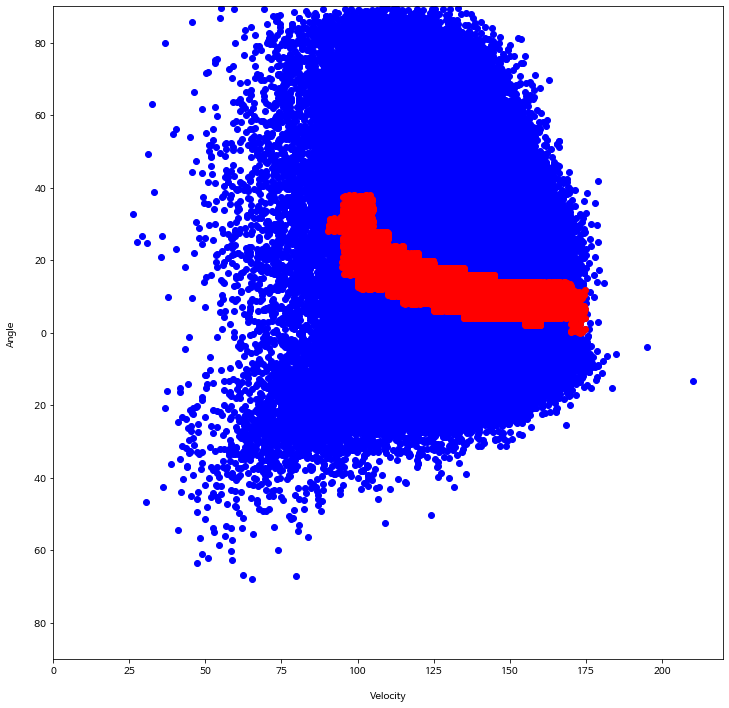

In [27]:
fig, ax = plt.subplots(figsize=(12,12))
ax.set_xlabel('Velocity', labelpad=15)
ax.set_ylabel('Angle', labelpad=15)
ax.set_xlim([0, 220])
ax.set_ylim([-90, 90])
ax.scatter(df['HIT_VEL'], df['HIT_ANG_VER'], c='b')

for i in range(barrel2_2_group.shape[0]):
    vel = barrel2_2_group.index[i]
    min_ang = barrel2_2_group.iloc[i][0]
    max_ang = barrel2_2_group.iloc[i][1]
    tmp = df[(df['HIT_VEL'] >= vel) & (df['HIT_VEL'] < vel+5) & (df['HIT_ANG_VER'] >= min_ang) & (df['HIT_ANG_VER'] < max_ang+2)]
    ax.scatter(tmp['HIT_VEL'], tmp['HIT_ANG_VER'], c='r')

2루타, 3루타, 홈런을 제외한 타구 중 직선타를 포함해 타율이 0.7 이상인 타구

In [95]:
barrel1_2_vel=[]
barrel1_2_ang=[]
barrel1_2_df = pd.DataFrame()

for vel in tqdm_notebook(range(25, 215, 5)) :
    for ang in range(-70, 90, 2) :
        tmp = df[(df['HIT_VEL'] >= vel) & (df['HIT_VEL'] < vel+5) & (df['HIT_ANG_VER'] >= ang) & (df['HIT_ANG_VER'] < ang+2)]
        total_num = len(tmp)
        hit_num = list(tmp['HA_result']).count('hit')

        HA_tmp = hit_num / total_num if total_num != 0  else 0

        b1_num = list(tmp['SLG_result']).count('1루타')
        b2_num = list(tmp['SLG_result']).count('2루타')
        b3_num = list(tmp['SLG_result']).count('3루타')
        hr_num = list(tmp['SLG_result']).count('홈런')

        SLG_tmp = ((1*b1_num) + (2*b2_num) + (3*b3_num) + (4*hr_num)) / total_num if total_num != 0  else 0

        pure_SLG = SLG_tmp - HA_tmp

        if (pure_SLG >= 0.5) & (total_num >= 10):
            barrel1_2_vel.append(vel)
            barrel1_2_ang.append(ang)

barrel1_2_df['VEL'] = barrel1_2_vel
barrel1_2_df['ANG'] = barrel1_2_ang

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/38 [00:00<?, ?it/s]

In [96]:
def group_fuc(x):
    d={}
    d['min'] = x['ANG'].min()
    d['max'] = x['ANG'].max()
    return pd.Series(d)

barrel1_2_group = barrel1_2_df.groupby(barrel1_2_df['VEL']).apply(group_fuc)

In [97]:
barrel1_2_group

,min,max
VEL,,
140,30,30
145,22,36
150,18,40
155,16,44
160,16,46
165,14,38
170,12,28


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


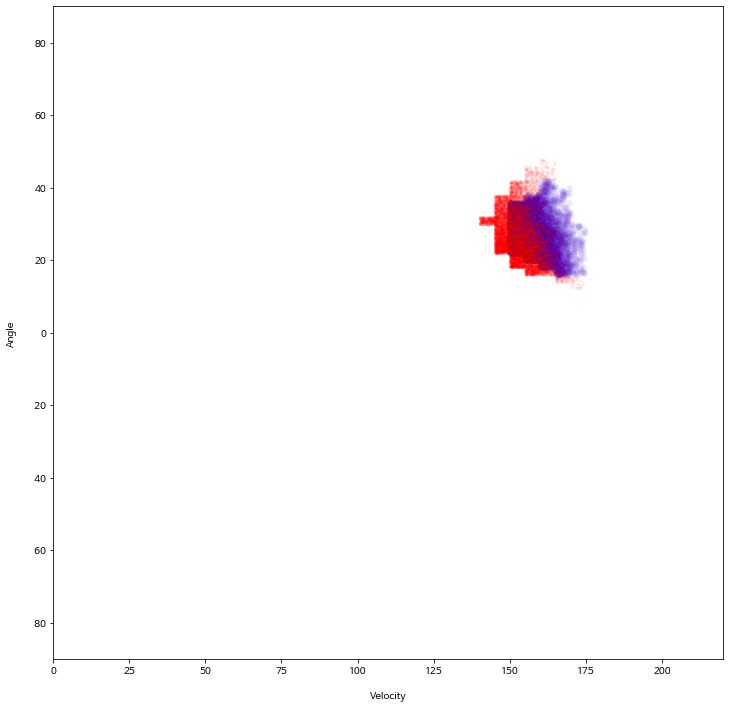

In [100]:
fig, ax = plt.subplots(figsize=(12,12))
ax.set_xlabel('Velocity', labelpad=15)
ax.set_ylabel('Angle', labelpad=15)
ax.set_xlim([0, 220])
ax.set_ylim([-90, 90])
# ax.scatter(df['HIT_VEL'], df['HIT_ANG_VER'], c='b')


for i in range(barrel_group.shape[0]):
    vel = barrel_group.index[i]
    min_ang = barrel_group.iloc[i][0]
    max_ang = barrel_group.iloc[i][1]
    tmp = df[(df['HIT_VEL'] >= vel) & (df['HIT_VEL'] < vel+5) & (df['HIT_ANG_VER'] >= min_ang) & (df['HIT_ANG_VER'] < max_ang+2)]
    ax.scatter(tmp['HIT_VEL'], tmp['HIT_ANG_VER'], c='b', alpha = 0.05)

for i in range(barrel1_2_group.shape[0]):
    vel = barrel1_2_group.index[i]
    min_ang = barrel1_2_group.iloc[i][0]
    max_ang = barrel1_2_group.iloc[i][1]
    tmp = df[(df['HIT_VEL'] >= vel) & (df['HIT_VEL'] < vel+5) & (df['HIT_ANG_VER'] >= min_ang) & (df['HIT_ANG_VER'] < max_ang+2)]
    ax.scatter(tmp['HIT_VEL'], tmp['HIT_ANG_VER'], c='r', s=5, alpha = 0.05)


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


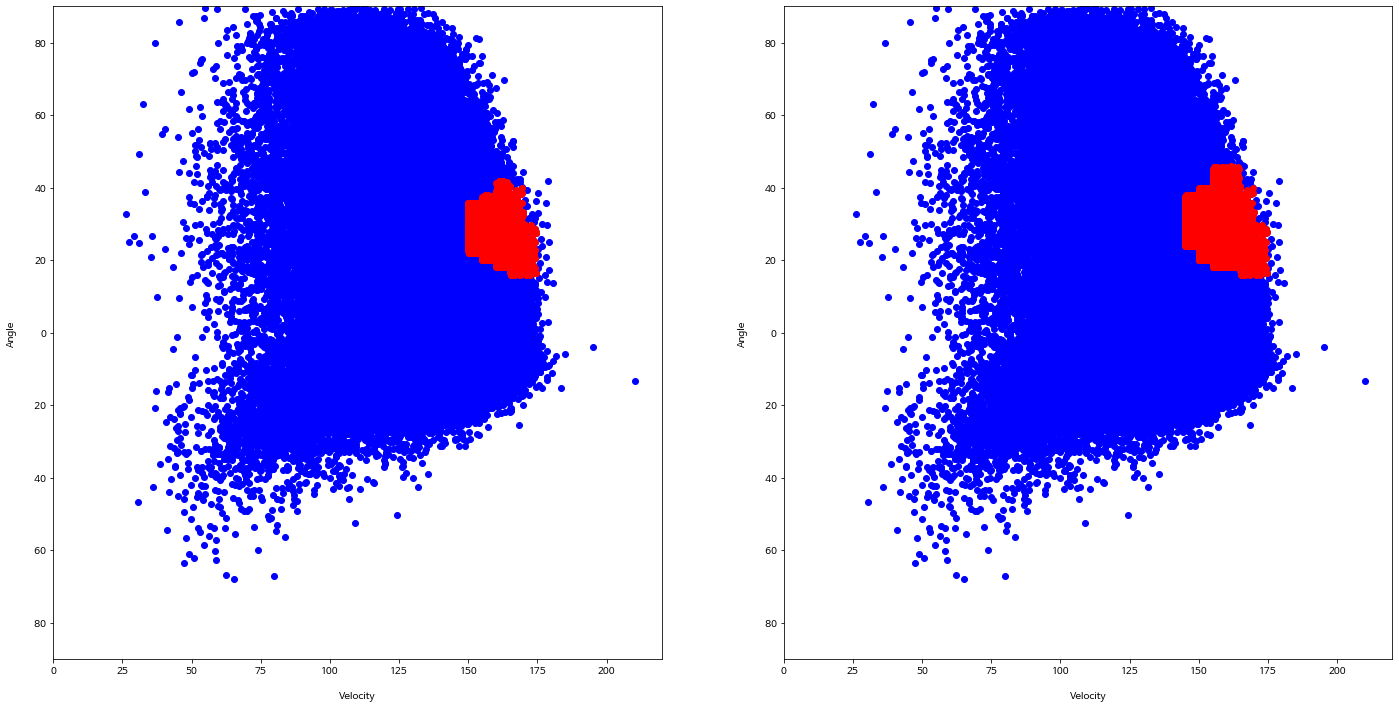

In [58]:
fig = plt.figure(figsize=(24,12))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.set_xlabel('Velocity', labelpad=15)
ax1.set_ylabel('Angle', labelpad=15)
ax1.set_xlim([0, 220])
ax1.set_ylim([-90, 90])
ax1.scatter(df['HIT_VEL'], df['HIT_ANG_VER'], c='b')
ax2.set_xlabel('Velocity', labelpad=15)
ax2.set_ylabel('Angle', labelpad=15)
ax2.set_xlim([0, 220])
ax2.set_ylim([-90, 90])
ax2.scatter(df['HIT_VEL'], df['HIT_ANG_VER'], c='b')

for i in range(barrel_group.shape[0]):
    vel = barrel_group.index[i]
    min_ang = barrel_group.iloc[i][0]
    max_ang = barrel_group.iloc[i][1]
    tmp = df[(df['HIT_VEL'] >= vel) & (df['HIT_VEL'] < vel+5) & (df['HIT_ANG_VER'] >= min_ang) & (df['HIT_ANG_VER'] < max_ang+2)]
    ax1.scatter(tmp['HIT_VEL'], tmp['HIT_ANG_VER'], c='r')
    
for i in range(barrel1_2_group.shape[0]):
    vel = barrel1_2_group.index[i]
    min_ang = barrel1_2_group.iloc[i][0]
    max_ang = barrel1_2_group.iloc[i][1]
    tmp = df[(df['HIT_VEL'] >= vel) & (df['HIT_VEL'] < vel+5) & (df['HIT_ANG_VER'] >= min_ang) & (df['HIT_ANG_VER'] < max_ang+2)]
    ax2.scatter(tmp['HIT_VEL'], tmp['HIT_ANG_VER'], c='r')

# WPa 와의 관계 찾아보기

In [28]:
df.head()

,DATE,PCODE,INN,HIT_VEL,HIT_ANG_VER,HIT_RESULT,PIT_VEL,PIT_ID,G_ID,RESULT_MG,order,NAME,POSITION,result,before,after,LEV,REa,WPs,WPe,WPa,P,pitcher,batter,vs,HA_result,HA2_result,SLG_result,SLG2_result,HA2_2_result
0,20180324,62797,1,131.50,42.7,플라이,149.59,180324_140436,20180324HHWO0,플라이,0.0,양성우,외,뜬공,1사 0:0,2사 0:0,0.62,-0.180,52.2,53.8,-0.016,1-2,로저스,양성우,넥센,out,out,out,out,out
1,20180324,76753,1,135.18,9.9,1루타,148.78,180324_140514,20180324HHWO0,1루타,0.0,송광민,내,안타,2사 0:0,2사 1루 0:0,0.40,0.134,53.8,52.6,0.012,0-0,로저스,송광민,넥센,hit,hit,1루타,1루타,hit
2,20180324,71752,1,152.41,2.1,1루타,148.59,180324_140647,20180324HHWO0,1루타,0.0,김태균,내,안타,2사 1루 0:0,"2사 1,2루 0:0",0.79,0.215,52.6,50.6,0.020,0-2,로저스,김태균,넥센,hit,hit,1루타,1루타,hit
3,20180324,62700,1,113.72,13.5,1루타,139.13,180324_140911,20180324HHWO0,1루타,0.0,하주석,내,안타,"2사 1,2루 0:0","2사 1,2루 1:0",1.62,1.000,50.6,40.7,0.099,2-1,로저스,하주석,넥센,hit,hit,1루타,1루타,hit
4,20180324,78288,2,161.90,3.5,1루타,145.75,180324_142310,20180324HHWO0,1루타,0.0,최재훈,포,안타,무사 2루 1:0,"무사 1,3루 1:0",1.13,0.715,33.8,27.9,0.059,0-2,로저스,최재훈,넥센,hit,hit,1루타,1루타,hit


In [29]:
df['WPa'].groupby(df['result']).mean().to_frame()

,WPa
result,
2루타,0.065886
3루타,0.094707
그라운드 홈런,0.151667
내야안타,0.033245
땅볼,-0.021316
땅볼 실책,-0.000218
뜬공,-0.023244
병살타,-0.067695
병살타 실책,-0.011333


In [30]:
df['WPa'].describe()

count    119504.000000
mean          0.005394
std           0.061112
min          -0.629000
25%          -0.023000
50%          -0.006000
75%           0.022000
max           0.910000
Name: WPa, dtype: float64

In [41]:
barrel3_vel=[]
barrel3_ang=[]
barrel3_wpa=[]
barrel3_df = pd.DataFrame()

for vel in tqdm_notebook(range(25, 215, 5)) :
    for ang in range(-70, 90, 2) :
        tmp = df[(df['HIT_VEL'] >= vel) & (df['HIT_VEL'] < vel+5) & (df['HIT_ANG_VER'] >= ang) & (df['HIT_ANG_VER'] < ang+2)]
        total_num = len(tmp)
        wpa_mean = tmp['WPa'].mean()

        if (wpa_mean >= 0.08) & (total_num >= 10):
            barrel3_vel.append(vel)
            barrel3_ang.append(ang)
            barrel3_wpa.append(wpa_mean)


barrel3_df['VEL'] = barrel3_vel
barrel3_df['ANG'] = barrel3_ang
barrel3_df['WPa'] = barrel3_wpa

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/38 [00:00<?, ?it/s]

In [43]:
def group_fuc(x):
    d={}
    d['min'] = x['ANG'].min()
    d['max'] = x['ANG'].max()
    return pd.Series(d)

barrel3_group = barrel3_df.groupby(barrel3_df['VEL']).apply(group_fuc)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


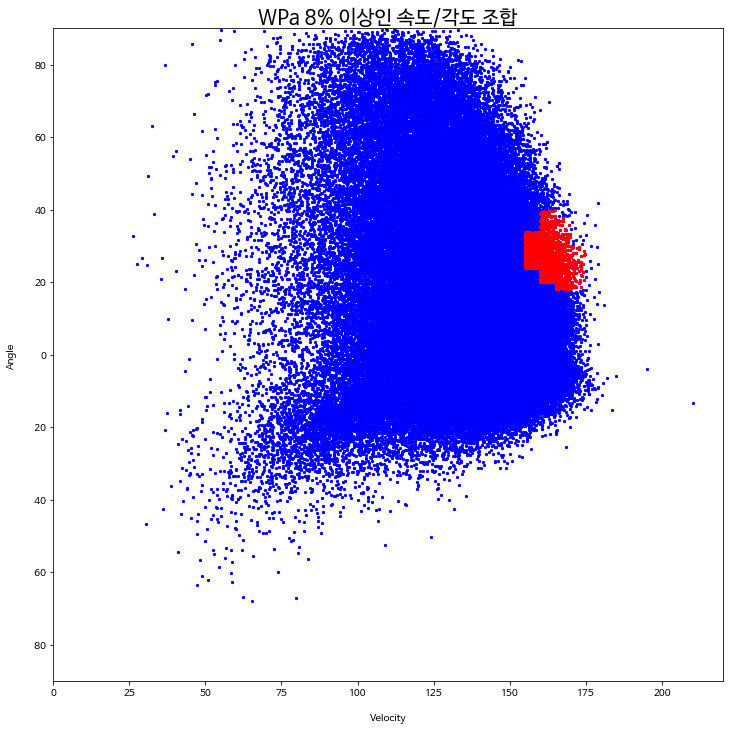

In [44]:
fig, ax = plt.subplots(figsize=(12,12))
ax.set_title('WPa 8% 이상인 속도/각도 조합', fontdict={'fontsize' : 20})
ax.set_xlabel('Velocity', labelpad=15)
ax.set_ylabel('Angle', labelpad=15)
ax.set_xlim([0, 220])
ax.set_ylim([-90, 90])
ax.scatter(df['HIT_VEL'], df['HIT_ANG_VER'], c='b', s=5)

for i in range(barrel3_group.shape[0]):
    vel = barrel3_group.index[i]
    min_ang = barrel3_group.iloc[i][0]
    max_ang = barrel3_group.iloc[i][1]
    tmp = df[(df['HIT_VEL'] >= vel) & (df['HIT_VEL'] < vel+5) & (df['HIT_ANG_VER'] >= min_ang) & (df['HIT_ANG_VER'] < max_ang+2)]
    ax.scatter(tmp['HIT_VEL'], tmp['HIT_ANG_VER'], c='r', s=5)

plt.show()

In [ ]:
df.groupby(barrel3_df['VEL']).apply(group_fuc)

# 상황별 기대득점 계산해보기

In [ ]:
df.head()

,DATE,PCODE,INN,HIT_VEL,HIT_ANG_VER,HIT_RESULT,PIT_VEL,PIT_ID,G_ID,RESULT_MG,order,NAME,POSITION,result,before,after,LEV,REa,WPs,WPe,WPa,P,pitcher,batter,vs,HA_result,HA2_result,SLG_result,SLG2_result
0,20180324,62797,1,131.50,42.7,플라이,149.59,180324_140436,20180324HHWO0,플라이,0.0,양성우,외,뜬공,1사 0:0,2사 0:0,0.62,-0.180,52.2,53.8,-0.016,1-2,로저스,양성우,넥센,out,out,out,out
1,20180324,76753,1,135.18,9.9,1루타,148.78,180324_140514,20180324HHWO0,1루타,0.0,송광민,내,안타,2사 0:0,2사 1루 0:0,0.40,0.134,53.8,52.6,0.012,0-0,로저스,송광민,넥센,hit,hit,1루타,1루타
2,20180324,71752,1,152.41,2.1,1루타,148.59,180324_140647,20180324HHWO0,1루타,0.0,김태균,내,안타,2사 1루 0:0,"2사 1,2루 0:0",0.79,0.215,52.6,50.6,0.020,0-2,로저스,김태균,넥센,hit,hit,1루타,1루타
3,20180324,62700,1,113.72,13.5,1루타,139.13,180324_140911,20180324HHWO0,1루타,0.0,하주석,내,안타,"2사 1,2루 0:0","2사 1,2루 1:0",1.62,1.000,50.6,40.7,0.099,2-1,로저스,하주석,넥센,hit,hit,1루타,1루타
4,20180324,78288,2,161.90,3.5,1루타,145.75,180324_142310,20180324HHWO0,1루타,0.0,최재훈,포,안타,무사 2루 1:0,"무사 1,3루 1:0",1.13,0.715,33.8,27.9,0.059,0-2,로저스,최재훈,넥센,hit,hit,1루타,1루타


In [ ]:
df['out_count'] = df['before'].apply(lambda x: x.split(' ')[0])
df['runner_count'] = df['before'].apply(lambda x: x.split(' ')[1])
df['before_score'] = df['before'].apply(lambda x: x.split(' ')[2])
df['after_score'] = df['after'].apply(lambda x: x.split(' ')[-1])
df['runner_count'].replace("", "주자없음", inplace=True)
df['situation'] = df['out_count'] + "/" + df['runner_count']

In [ ]:
df['out_count'].value_counts()

무사    41395
1사    40351
2사    37758
Name: out_count, dtype: int64

In [ ]:
df['runner_count'].value_counts()

주자없음    63761
1루      23650
1,2루     9726
2루       9086
1,3루     4166
만루       3856
3루       2750
2,3루     2509
Name: runner_count, dtype: int64

In [ ]:
df['situation'].value_counts().index

Index(['무사/주자없음', '1사/주자없음', '2사/주자없음', '1사/1루', '2사/1루', '무사/1루', '2사/1,2루',
       '2사/2루', '1사/1,2루', '1사/2루', '2사/1,3루', '무사/1,2루', '2사/만루', '무사/2루',
       '1사/1,3루', '2사/3루', '1사/만루', '2사/2,3루', '1사/2,3루', '1사/3루', '무사/1,3루',
       '무사/만루', '무사/2,3루', '무사/3루'],
      dtype='object')

In [ ]:
tmp1_1 = df['before_score'].apply(lambda x:x.split(':')[0])
tmp1_2 = df['before_score'].apply(lambda x:x.split(':')[1])

tmp2_1 = df['after_score'].apply(lambda x:x.split(':')[0])
tmp2_2 = df['after_score'].apply(lambda x:x.split(':')[1])

score_diff =  []
for i in range(len(tmp1_1)):
    b1 = int(tmp1_1[i])
    b2 = int(tmp1_2[i])
    a1 = int(tmp2_1[i])
    a2 = int(tmp2_2[i])
    if a1 - b1 != 0:
        score_diff.append(a1-b1)
    else:
        score_diff.append(a2-b2)


df['score_diff'] = score_diff

In [ ]:
df.groupby(df['situation']).mean()

,DATE,PCODE,INN,HIT_VEL,HIT_ANG_VER,PIT_VEL,order,LEV,REa,WPs,WPe,WPa,score_diff
situation,,,,,,,,,,,,,
"1사/1,2루",2.019377e+07,69816.823449,5.102487,134.215261,18.259169,135.195922,0.000547,1.706567,0.102133,50.869664,50.957147,0.009385,0.409948
"1사/1,3루",2.019337e+07,70220.848232,4.879100,134.154547,18.985145,134.845453,0.001929,1.565762,0.136503,50.650354,50.653376,0.012207,0.807074
1사/1루,2.019374e+07,69782.508206,4.956699,134.726565,17.452997,135.714272,0.000000,1.048751,0.059251,50.129112,50.268164,0.005282,0.120708
"1사/2,3루",2.019436e+07,69615.923464,4.764350,131.921641,17.227291,135.858147,0.000000,1.380846,0.194731,51.630111,52.049849,0.014521,1.070493
1사/2루,2.019345e+07,70011.749926,4.920177,132.839343,15.964094,134.872118,0.000295,1.111885,0.101048,50.467629,50.516848,0.008110,0.306333
1사/3루,2.019358e+07,70096.410020,4.709611,132.708528,16.763292,135.605389,0.001022,1.238538,0.170291,49.735685,49.884969,0.014238,0.773006
1사/만루,2.019459e+07,69840.684246,5.215686,132.915497,18.061055,135.930426,0.003381,2.374990,0.158553,49.763489,49.772076,0.006534,1.053414
1사/주자없음,2.019363e+07,69760.957515,4.947211,134.119160,17.323872,136.161007,0.000305,0.588444,0.029092,50.428851,50.451693,0.002814,0.039034
"2사/1,2루",2.019428e+07,69714.075371,4.969852,133.061046,18.553641,135.284889,0.008349,1.398453,0.152804,50.730775,50.715167,0.011954,0.455009


# 기대득점보다 높은 득점을 기록한 타구속도/발사각도 조합 찾아보기

In [101]:
hr_num = 0
ha_num = 0
b1_num = 0
b2_num = 0
b3_num = 0

for i in range(barrel_group.shape[0]):
    vel = barrel_group.index[i]
    min_ang = barrel_group.iloc[i][0]
    max_ang = barrel_group.iloc[i][1]
    tmp = df[(df['HIT_VEL'] >= vel) & (df['HIT_VEL'] < vel+5) & (df['HIT_ANG_VER'] >= min_ang) & (df['HIT_ANG_VER'] < max_ang+2)]
    hr_num += list(tmp['RESULT_MG']).count('홈런')
    b1_num += list(tmp['RESULT_MG']).count('1루타')
    b2_num += list(tmp['RESULT_MG']).count('2루타')
    b3_num += list(tmp['RESULT_MG']).count('3루타')
    ha_num += len(tmp)

print('총 타석 수 : {}, 안타 수 : {}, 2루타 : {}, 3루타 : {}, 홈런 수 : {}, 홈런 비율 : {}, 아웃 : {}'.format(ha_num, b1_num, b2_num, b3_num, hr_num, hr_num/ha_num, ha_num-b1_num-b2_num-b3_num-hr_num))

총 타석 수 : 5827, 안타 수 : 84, 2루타 : 1033, 3루타 : 103, 홈런 수 : 3273, 홈런 비율 : 0.5616955551741891, 아웃 : 1334


In [102]:
hr_num = 0
ha_num = 0
b1_num = 0
b2_num = 0
b3_num = 0

for i in range(barrel1_2_group.shape[0]):
    vel = barrel1_2_group.index[i]
    min_ang = barrel1_2_group.iloc[i][0]
    max_ang = barrel1_2_group.iloc[i][1]
    tmp = df[(df['HIT_VEL'] >= vel) & (df['HIT_VEL'] < vel+5) & (df['HIT_ANG_VER'] >= min_ang) & (df['HIT_ANG_VER'] < max_ang+2)]
    hr_num += list(tmp['RESULT_MG']).count('홈런')
    b1_num += list(tmp['RESULT_MG']).count('1루타')
    b2_num += list(tmp['RESULT_MG']).count('2루타')
    b3_num += list(tmp['RESULT_MG']).count('3루타')
    ha_num += len(tmp)

print('총 타석 수 : {}, 안타 수 : {}, 2루타 : {}, 3루타 : {}, 홈런 수 : {}, 홈런 비율 : {}, 아웃 : {}'.format(ha_num, b1_num, b2_num, b3_num, hr_num, hr_num/ha_num, ha_num-b1_num-b2_num-b3_num-hr_num))

총 타석 수 : 11573, 안타 수 : 258, 2루타 : 2377, 3루타 : 217, 홈런 수 : 4233, 홈런 비율 : 0.3657651430052709, 아웃 : 4488
